<a href="https://colab.research.google.com/github/amrashraf15/RegularExpression-To-DFA/blob/main/Ass1(REtoDFA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import json
from graphviz import Digraph
from itertools import count

Classes


In [23]:
class State:
    def __init__(self, name):
        self.name = name
        self.transitions = {}
        self.is_EndState = False
        self.is_StartState = False

In [ ]:
class DFA:
    def __init__(self):
        self.startState = None
        self.states = {}
        self.transitions = {} 
        self.acceptingStates = set()  
    def from_json(self, json_data):
        data= json.loads(json_data)
        start_state_name = data["startingState"]
        for state_name,state_info in data.items():
            if state_name== "startingState":
                continue
            state = State(state_name)
            state.is_EndState = state_info["isTerminatingState"]
            
            if state_name == start_state_name:
                state.is_StartState = True
                self.startState = state
            
            if state.is_EndState:
                self.acceptingStates.add(state_name)
            self.states[state_name] = state

        for state_name, state_info in data.items():
            if state_name == "startingState":
                continue
            
            current_state = self.states[state_name]
            
            for symbol, next_state_name in state_info.items():
                if symbol != "isTerminatingState":
                    current_state.transitions[symbol] = next_state_name
        
    def get_reachable_states(self):
            visited = set()
            to_explore = [self.startState.name]
    
            while to_explore:
               current_state_name = to_explore.pop()

               if current_state_name in visited:
                   continue
               visited.add(current_state_name)
               current_state = self.states[current_state_name]
               for next_state_name in current_state.transitions.values():
                   if next_state_name not in visited:
                       to_explore.append(next_state_name)
            return visited

    def Minimize(self,state_names=None):
        visited = self.get_reachable_states()
        state_names = visited
        accepting= set()
        non_accepting= set()
        for state_name in state_names:
            if self.states[state_name].is_EndState==True:
                accepting.add(state_name)
            else:
                non_accepting.add(state_name)
        # Filter out empty sets
        partitions = [p for p in [accepting, non_accepting] if len(p) > 0]
        
        while True:
            new_partitions= []
            for group in partitions:
                if len(group) == 0:
                    continue
                groups_dict= {}
                for state_name in group:
                    key= []
                    for symbol in sorted(self.states[state_name].transitions.keys()):
                        next_state_name= self.states[state_name].transitions[symbol]
                        for index,part in enumerate(partitions):
                            if next_state_name in part:
                                key.append((symbol,index))
                                break
                    key= tuple(key)
                    if key not in groups_dict:
                        groups_dict[key]= set()
                    groups_dict[key].add(state_name)
                new_partitions.extend(groups_dict.values())
            if len(new_partitions)== len(partitions):
                break
            partitions= new_partitions
        
        # new minimized states
        new_states= {}
        state_mapping = {}
        
        for index,group in enumerate(partitions):
            new_state_name= f'Q{index}'
            new_state= State(new_state_name)
            
            for old_state_name in group:
                state_mapping[old_state_name] = new_state_name
            
            if any(self.states[state_name].is_EndState for state_name in group):
                new_state.is_EndState= True
            if any(self.states[state_name].is_StartState for state_name in group):
                new_state.is_StartState= True
                self.startState= new_state
                
            new_states[new_state_name]= new_state
            
        # Build transitions for new states
        for index,group in enumerate(partitions):
            new_state_name= f'Q{index}'
            representative= next(iter(group))
            for symbol,next_state_name in self.states[representative].transitions.items():
                # Find which partition the next state belongs to
                new_next_state = state_mapping[next_state_name]
                new_states[new_state_name].transitions[symbol]= new_next_state
                        
        # Update accepting states set
        self.acceptingStates = set()
        for state_name, state in new_states.items():
            if state.is_EndState:
                self.acceptingStates.add(state_name)
                
        self.states= new_states
    
    def to_json(self):
        result = {"startingState": self.startState.name}
        
        for state_name, state in sorted(self.states.items()):
            state_dict = {"isTerminatingState": state.is_EndState}
            for symbol, next_state in sorted(state.transitions.items()):
                state_dict[symbol] = next_state
            result[state_name] = state_dict
        
        return json.dumps(result, indent=2)
    
    def visualize(self, filename="dfa_graph"):
        """
        Generate a professional graph visualization of the DFA using Graphviz.
        Graphviz is the industry standard for automata visualization.
        """
        # Create a new directed graph
        dot = Digraph(comment='Minimized DFA')
        
        # Set graph attributes for better layout
        dot.attr(rankdir='LR')  # Left to right layout
        dot.attr('graph', 
                 bgcolor='white',
                 dpi='300',
                 fontname='Arial',
                 fontsize='12',
                 splines='true',  # Enable curved edges
                 overlap='false',
                 nodesep='0.8',
                 ranksep='1.2')
        
        # Set default node attributes
        dot.attr('node',
                 fontname='Arial',
                 fontsize='14',
                 style='filled',
                 fontcolor='black')
        
        # Set default edge attributes  
        dot.attr('edge',
                 fontname='Arial',
                 fontsize='12',
                 fontcolor='black',
                 color='#2C3E50',
                 arrowsize='0.8')
        
        # Add an invisible start node for the start arrow
        dot.node('__start__', '', shape='none', width='0', height='0')
        
        # Add all states
        for state_name, state in self.states.items():
            if state.is_EndState:
                # Accepting state: double circle with green color
                dot.node(state_name, state_name,
                        shape='doublecircle',
                        fillcolor='#90EE90',
                        color='#228B22',
                        penwidth='2.5')
            else:
                # Non-accepting state: single circle with blue color
                dot.node(state_name, state_name,
                        shape='circle',
                        fillcolor='#87CEEB',
                        color='#1E90FF',
                        penwidth='2.5')
        
        # Add start arrow
        dot.edge('__start__', self.startState.name,
                color='#FF6347',
                penwidth='2.5',
                label='START',
                fontcolor='#FF6347',
                fontsize='11',
                fontweight='bold')
        
        # Group transitions by (source, destination) to combine labels
        edge_labels = {}
        for state_name, state in self.states.items():
            for symbol, next_state_name in state.transitions.items():
                edge_key = (state_name, next_state_name)
                if edge_key not in edge_labels:
                    edge_labels[edge_key] = []
                edge_labels[edge_key].append(symbol)
        
        # Add transitions with combined labels
        for (source, destination), symbols in edge_labels.items():
            label = ', '.join(sorted(symbols))
            
            # Style self-loops differently
            if source == destination:
                dot.edge(source, destination,
                        label=label,
                        color='#2C3E50',
                        penwidth='2.0',
                        fontsize='11')
            else:
                dot.edge(source, destination,
                        label=label,
                        penwidth='2.0',
                        fontsize='11')
        
        # Render the graph
        try:
            dot.render(filename, format='png', cleanup=True)
            print(f"✓ Graph saved as {filename}.png")
            
            # Also save the DOT source for reference
            with open(f'{filename}.dot', 'w') as f:
                f.write(dot.source)
            print(f"✓ DOT source saved as {filename}.dot")
            
        except Exception as e:
            print(f"✗ Error generating graph: {e}")
            print("\nNote: Graphviz requires both:")
            print("1. Python package: pip install graphviz")
            print("2. Graphviz executables: https://graphviz.org/download/")
            print("   After installation, add Graphviz bin folder to system PATH")
            print("\n💡 Tip: You can copy the DOT source and paste it at:")
            print("   https://dreampuf.github.io/GraphvizOnline/")
            
        # Always return the dot object so the source can be accessed
        return dot

In [ ]:
test_json = '''
{
  "startingState": "S0",
  "S0": {
    "isTerminatingState": false,
    "A": "S1",
    "B": "S0"
  },
  "S1": {
    "isTerminatingState": true,
    "A": "S1",
    "B": "S1"
  }
}
'''

dfa = DFA()
dfa.from_json(test_json)
reachable = dfa.get_reachable_states()

print(f"Reachable states: {reachable}")

Reachable states: {'S1', 'S0'}


In [29]:
# Test DFA minimization
print("=== Original DFA ===")
dfa = DFA()
dfa.from_json(test_json)
print(f"States: {list(dfa.states.keys())}")
print(f"Start state: {dfa.startState.name}")
print(f"Accepting states: {dfa.acceptingStates}")
print("\nTransitions:")
for state_name, state in sorted(dfa.states.items()):
    for symbol, next_state in sorted(state.transitions.items()):
        print(f"  {state_name} --{symbol}--> {next_state}")

# Minimize the DFA
print("\n=== Minimizing DFA ===")
dfa.Minimize()

print(f"\nMinimized States: {list(dfa.states.keys())}")
print(f"Start state: {dfa.startState.name}")
print(f"Accepting states: {dfa.acceptingStates}")
print("\nMinimized Transitions:")
for state_name, state in sorted(dfa.states.items()):
    for symbol, next_state in sorted(state.transitions.items()):
        print(f"  {state_name} --{symbol}--> {next_state}")

# Output JSON
print("\n=== JSON Output ===")
json_output = dfa.to_json()
print(json_output)

# Save JSON to file
with open("minimized_dfa.json", "w") as f:
    f.write(json_output)
print("\nJSON saved to minimized_dfa.json")

# Visualize
print("\n=== Generating Visualization ===")
dfa.visualize("minimized_dfa")

=== Original DFA ===
States: ['S0', 'S1']
Start state: S0
Accepting states: {'S1'}

Transitions:
  S0 --A--> S1
  S0 --B--> S0
  S1 --A--> S1
  S1 --B--> S1

=== Minimizing DFA ===

Minimized States: ['Q0', 'Q1']
Start state: Q1
Accepting states: {'Q0'}

Minimized Transitions:
  Q0 --A--> Q0
  Q0 --B--> Q0
  Q1 --A--> Q0
  Q1 --B--> Q1

=== JSON Output ===
{
  "startingState": "Q1",
  "Q0": {
    "isTerminatingState": true,
    "A": "Q0",
    "B": "Q0"
  },
  "Q1": {
    "isTerminatingState": false,
    "A": "Q0",
    "B": "Q1"
  }
}

JSON saved to minimized_dfa.json

=== Generating Visualization ===
✗ Error generating graph: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

Note: Graphviz requires both:
1. Python package: pip install graphviz
2. Graphviz executables: https://graphviz.org/download/
   After installation, add Graphviz bin folder to system PATH

💡 Tip: You can copy the DOT source and paste it at:
   https://dreampuf.githu

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

## Alternative: Visualize Online (if Graphviz not installed)

If you don't have Graphviz executables installed, you can:

1. Get the DOT source from the DFA object
2. Copy it to an online Graphviz viewer like:
   - https://dreampuf.github.io/GraphvizOnline/
   - https://edotor.net/

Run the cell below to get the DOT source code:

In [30]:
# Generate DOT source for online visualization
dot = dfa.visualize("minimized_dfa")

if dot:
    print("\n" + "="*60)
    print("Copy the DOT source below to: https://dreampuf.github.io/GraphvizOnline/")
    print("="*60)
    print(dot.source)
    print("="*60)

✗ Error generating graph: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

Note: Graphviz requires both:
1. Python package: pip install graphviz
2. Graphviz executables: https://graphviz.org/download/
   After installation, add Graphviz bin folder to system PATH

💡 Tip: You can copy the DOT source and paste it at:
   https://dreampuf.github.io/GraphvizOnline/

Copy the DOT source below to: https://dreampuf.github.io/GraphvizOnline/
// Minimized DFA
digraph {
	rankdir=LR
	graph [bgcolor=white dpi=300 fontname=Arial fontsize=12 nodesep=0.8 overlap=false ranksep=1.2 splines=true]
	node [fontcolor=black fontname=Arial fontsize=14 style=filled]
	edge [arrowsize=0.8 color="#2C3E50" fontcolor=black fontname=Arial fontsize=12]
	__start__ [label="" height=0 shape=none width=0]
	Q0 [label=Q0 color="#228B22" fillcolor="#90EE90" penwidth=2.5 shape=doublecircle]
	Q1 [label=Q1 color="#1E90FF" fillcolor="#87CEEB" penwidth=2.5 shape=circle]
	__start__

=== Complex DFA Test ===
Original States: ['S0', 'S1', 'S2', 'S3', 'S4']
Original Accepting states: {'S4', 'S3'}

Minimized States: ['Q0', 'Q1', 'Q2']
Minimized Accepting states: {'Q0'}

Minimized Transitions:
  Q0 --0--> Q0
  Q0 --1--> Q0
  Q1 --0--> Q0
  Q1 --1--> Q0
  Q2 --0--> Q1
  Q2 --1--> Q1

JSON Output:
{
  "startingState": "Q2",
  "Q0": {
    "isTerminatingState": true,
    "0": "Q0",
    "1": "Q0"
  },
  "Q1": {
    "isTerminatingState": false,
    "0": "Q0",
    "1": "Q0"
  },
  "Q2": {
    "isTerminatingState": false,
    "0": "Q1",
    "1": "Q1"
  }
}
Graph saved as minimized_dfa_complex.png
Graph saved as minimized_dfa_complex.png


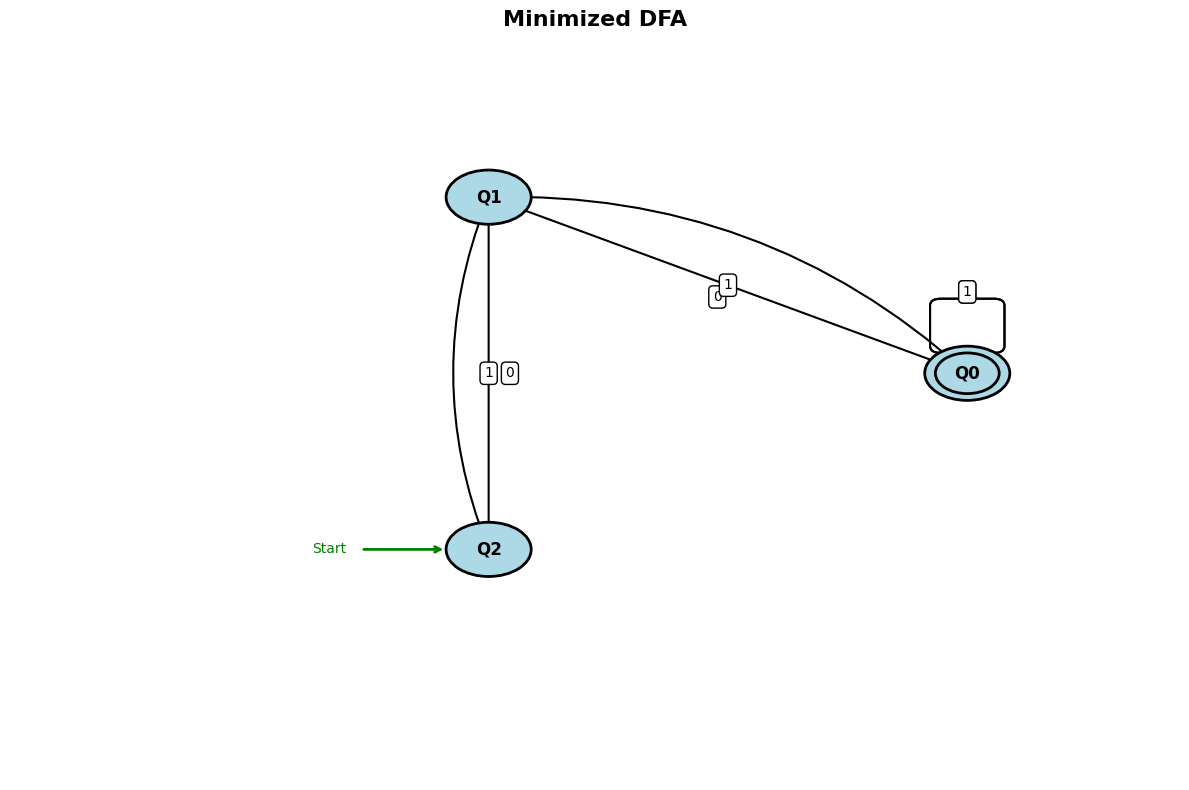

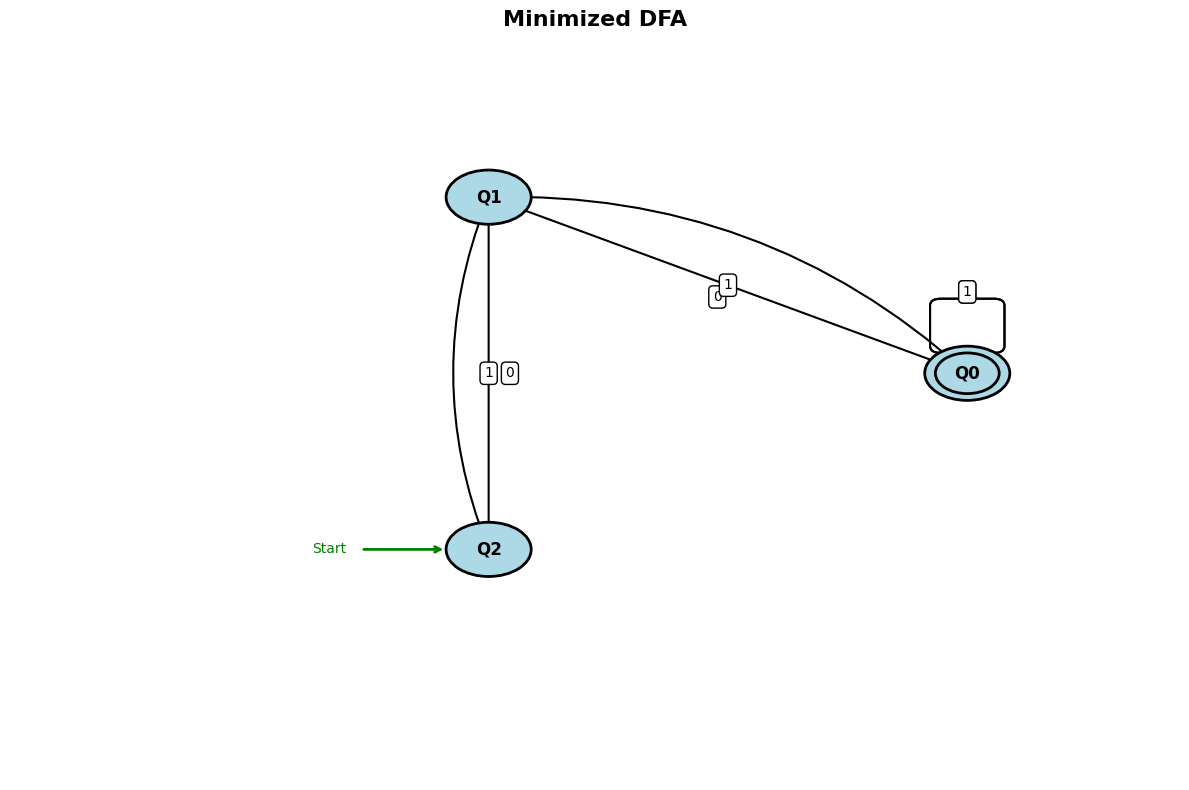

In [19]:
# Test with a more complex DFA that needs minimization
complex_json = '''
{
  "startingState": "S0",
  "S0": {
    "isTerminatingState": false,
    "0": "S1",
    "1": "S2"
  },
  "S1": {
    "isTerminatingState": false,
    "0": "S3",
    "1": "S4"
  },
  "S2": {
    "isTerminatingState": false,
    "0": "S4",
    "1": "S3"
  },
  "S3": {
    "isTerminatingState": true,
    "0": "S3",
    "1": "S3"
  },
  "S4": {
    "isTerminatingState": true,
    "0": "S4",
    "1": "S4"
  }
}
'''

print("=== Complex DFA Test ===")
dfa2 = DFA()
dfa2.from_json(complex_json)
print(f"Original States: {list(dfa2.states.keys())}")
print(f"Original Accepting states: {dfa2.acceptingStates}")

# Minimize
dfa2.Minimize()
print(f"\nMinimized States: {list(dfa2.states.keys())}")
print(f"Minimized Accepting states: {dfa2.acceptingStates}")

print("\nMinimized Transitions:")
for state_name, state in sorted(dfa2.states.items()):
    for symbol, next_state in sorted(state.transitions.items()):
        print(f"  {state_name} --{symbol}--> {next_state}")

# Save and visualize
json_output2 = dfa2.to_json()
print(f"\nJSON Output:\n{json_output2}")

with open("minimized_dfa_complex.json", "w") as f:
    f.write(json_output2)

dfa2.visualize("minimized_dfa_complex")